In [3]:
!nvidia-smi

Wed Nov  8 14:09:28 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.26                 Driver Version: 375.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:02:00.0     Off |                  N/A |
|  0%   37C    P8    14W / 200W |   7929MiB /  8113MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:03:00.0     Off |                  N/A |
|  0%   37C    P8    15W / 200W |      0MiB /  8112MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
import tensorflow as tf
import numpy as np
import sys
import os

sys.path.append(os.path.join("..", "..", ".."))
import cardio.dataset as ds
from cardio import EcgBatch
from cardio.dataset import F, V
from cardio.models.fft_model import FFTModel

%env CUDA_VISIBLE_DEVICES=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
config.gpu_options.allow_growth=True

Using TensorFlow backend.


env: CUDA_VISIBLE_DEVICES=0


## Train pipeline

In [3]:
model_config = {
    "input_shape": F(lambda batch: batch.signal[0].shape),
    "loss": "binary_crossentropy",
    "optimizer": "adam"
}

def make_data(batch, **kwagrs):
    return {'x': np.array(list(batch.signal)), 'y': batch.target}
    
train_pipeline = (ds.Pipeline()
                  .init_model("dynamic", FFTModel, name="fft_model", config=model_config)
                  .init_variable("loss_history", init=list)
                  .init_variable("true_targets", init=list)
                  .load(fmt="wfdb", components=["signal", "meta"])
                  .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                        fmt="csv", components="target")
                  .drop_labels(["~"])
                  .replace_labels({"N": "NO", "O": "NO"})
                  .random_resample_signals("normal", loc=300, scale=10)
                  .drop_short_signals(4000)
                  .split_signals(3000, 3000)
                  .binarize_labels()
                  .apply(np.transpose , axes=[0, 2, 1])
                  .ravel()
                  .get_targets('true_targets')
                  .train_model('fft_model', make_data=make_data,
                               save_to=V("loss_history"), mode="a")
                  .run(batch_size=300, shuffle=True,
                       drop_last=True, n_epochs=1, prefetch=0, lazy=True))

In [5]:
index = ds.FilesIndex(path="/notebooks/data/ECG/training2017/*.hea", no_ext=True, sort=True)
eds = ds.Dataset(index, batch_class=EcgBatch)
eds.cv_split(0.8)
fft_trained = (eds.test >> train_pipeline).run()

## Show loss and metric on train

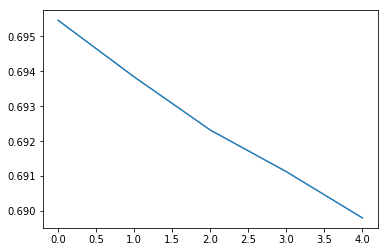

In [6]:
plt.plot(fft_trained.get_variable("loss_history"))
plt.show()

## Save model

In [7]:
(fft_trained.get_model_by_name("fft_model")
            .save("/notebooks/e_illarionov/ecg_repo/model_dump/fft_latest"))

## Test pipeline

In [8]:
test_pipeline = (ds.Pipeline()
                 .import_model("fft_model", train_pipeline)
                 .init_variable("pred_targets", init=list)
                 .init_variable("true_targets", init=list)
                 .load(fmt="wfdb", components=["signal", "meta"])
                 .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                       fmt="csv", components="target")
                 .drop_labels(["~"])
                 .replace_labels({"N": "NO", "O": "NO"})
                 .random_resample_signals("normal", loc=300, scale=10)
                 .drop_short_signals(4000)
                 .split_signals(3000, 3000)
                 .binarize_labels()
                 .apply(np.transpose , axes=[0, 2, 1])
                 .ravel()
                 .get_targets('true_targets', mode='e')
                 .predict_model('fft_model', make_data=make_data,
                                save_to=V("pred_targets"), mode="e", metrics=f1_score))

In [10]:
res_test = (eds.test >> test_pipeline).run(batch_size=300, shuffle=False, drop_last=False,
                                           n_epochs=1, prefetch=0)

In [20]:
f1_score(np.array(res_test.get_variable("true_targets"))[:, 0],
         np.rint(res_test.get_variable("pred_targets"))[:, 0], average='macro')

0.16159239747010032